This is a notebook for training a transformer based classifier that predicts the party affiliations of the speakers of speeches held in the Finnish Parliament.

This is based largely on https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_bert.ipynb

### Setup

In [ ]:
# Import comet_ml for logging and plotting
# comet_ml must be imported before other ML frameworks for it to work properly

import comet_ml

comet_ml.init(project_name = 'semparl-classifier')

COMET INFO: Comet API key is valid


In [23]:
# Import required modules
from pprint import PrettyPrinter
pprint = PrettyPrinter(compact=True).pprint

from datasets import load_dataset
import transformers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [66]:
# Setup data paths

xp_name = 'jupyter_model1' # Name of experiment that will be used to identify saved files

train_data = '../data/parl_speeches_2000-2021_threeparties_train.csv'
validation_data = '../data/parl_speeches_2000-2021_threeparties_validation.csv'
test_data = '../data/parl_speeches_2000-2021_threeparties_test.csv'
cache_dir = '../hf_cache' #hf cache can get bloated with multiple runs so save to disk with enough storage
output_dir = f'../results/models/{xp_name}' # Where the checkpoints are saved

### Data preprocess

In [25]:
# Load in train and test data
print('Loading dataset...')

# Speeches between 2000 and 2001 from the three parties that held the bulk of speehces: KOK, SD, KESK
# The data has been shuffled, i.e., its not in chronological order
dataset = load_dataset('csv', data_files = {'train': train_data,
                                            'validation' : validation_data,
                                            'test': test_data},
                      cache_dir = cache_dir) 

# Shuffle the dataset for good measure
dataset=dataset.shuffle()

Loading dataset...


Using custom data configuration default-0a8c1d234df091ff


Extracting data files: 100%|██████████| 3/3 [00:00<00:00, 189.34it/s]


Dataset csv downloaded and prepared to ../hf_cache/csv/default-0a8c1d234df091ff/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 31.58it/s]


In [67]:
# Let's see how the labels are distributed in the data
train_data = pd.read_csv(train_data)
validation_data = pd.read_csv(validation_data)
test_data = pd.read_csv(test_data)
print('Label distribution')
pprint(train_data['label'].value_counts(normalize = True))
pprint(validation_data['label'].value_counts(normalize = True))
pprint(test_data['label'].value_counts(normalize = True))

Label distribution
2    0.343094
0    0.330110
1    0.326796
Name: label, dtype: float64
2    0.337036
0    0.333275
1    0.329689
Name: label, dtype: float64
2    0.340289
0    0.332706
1    0.327004
Name: label, dtype: float64


Text(0, 0.5, 'Number of speeches')

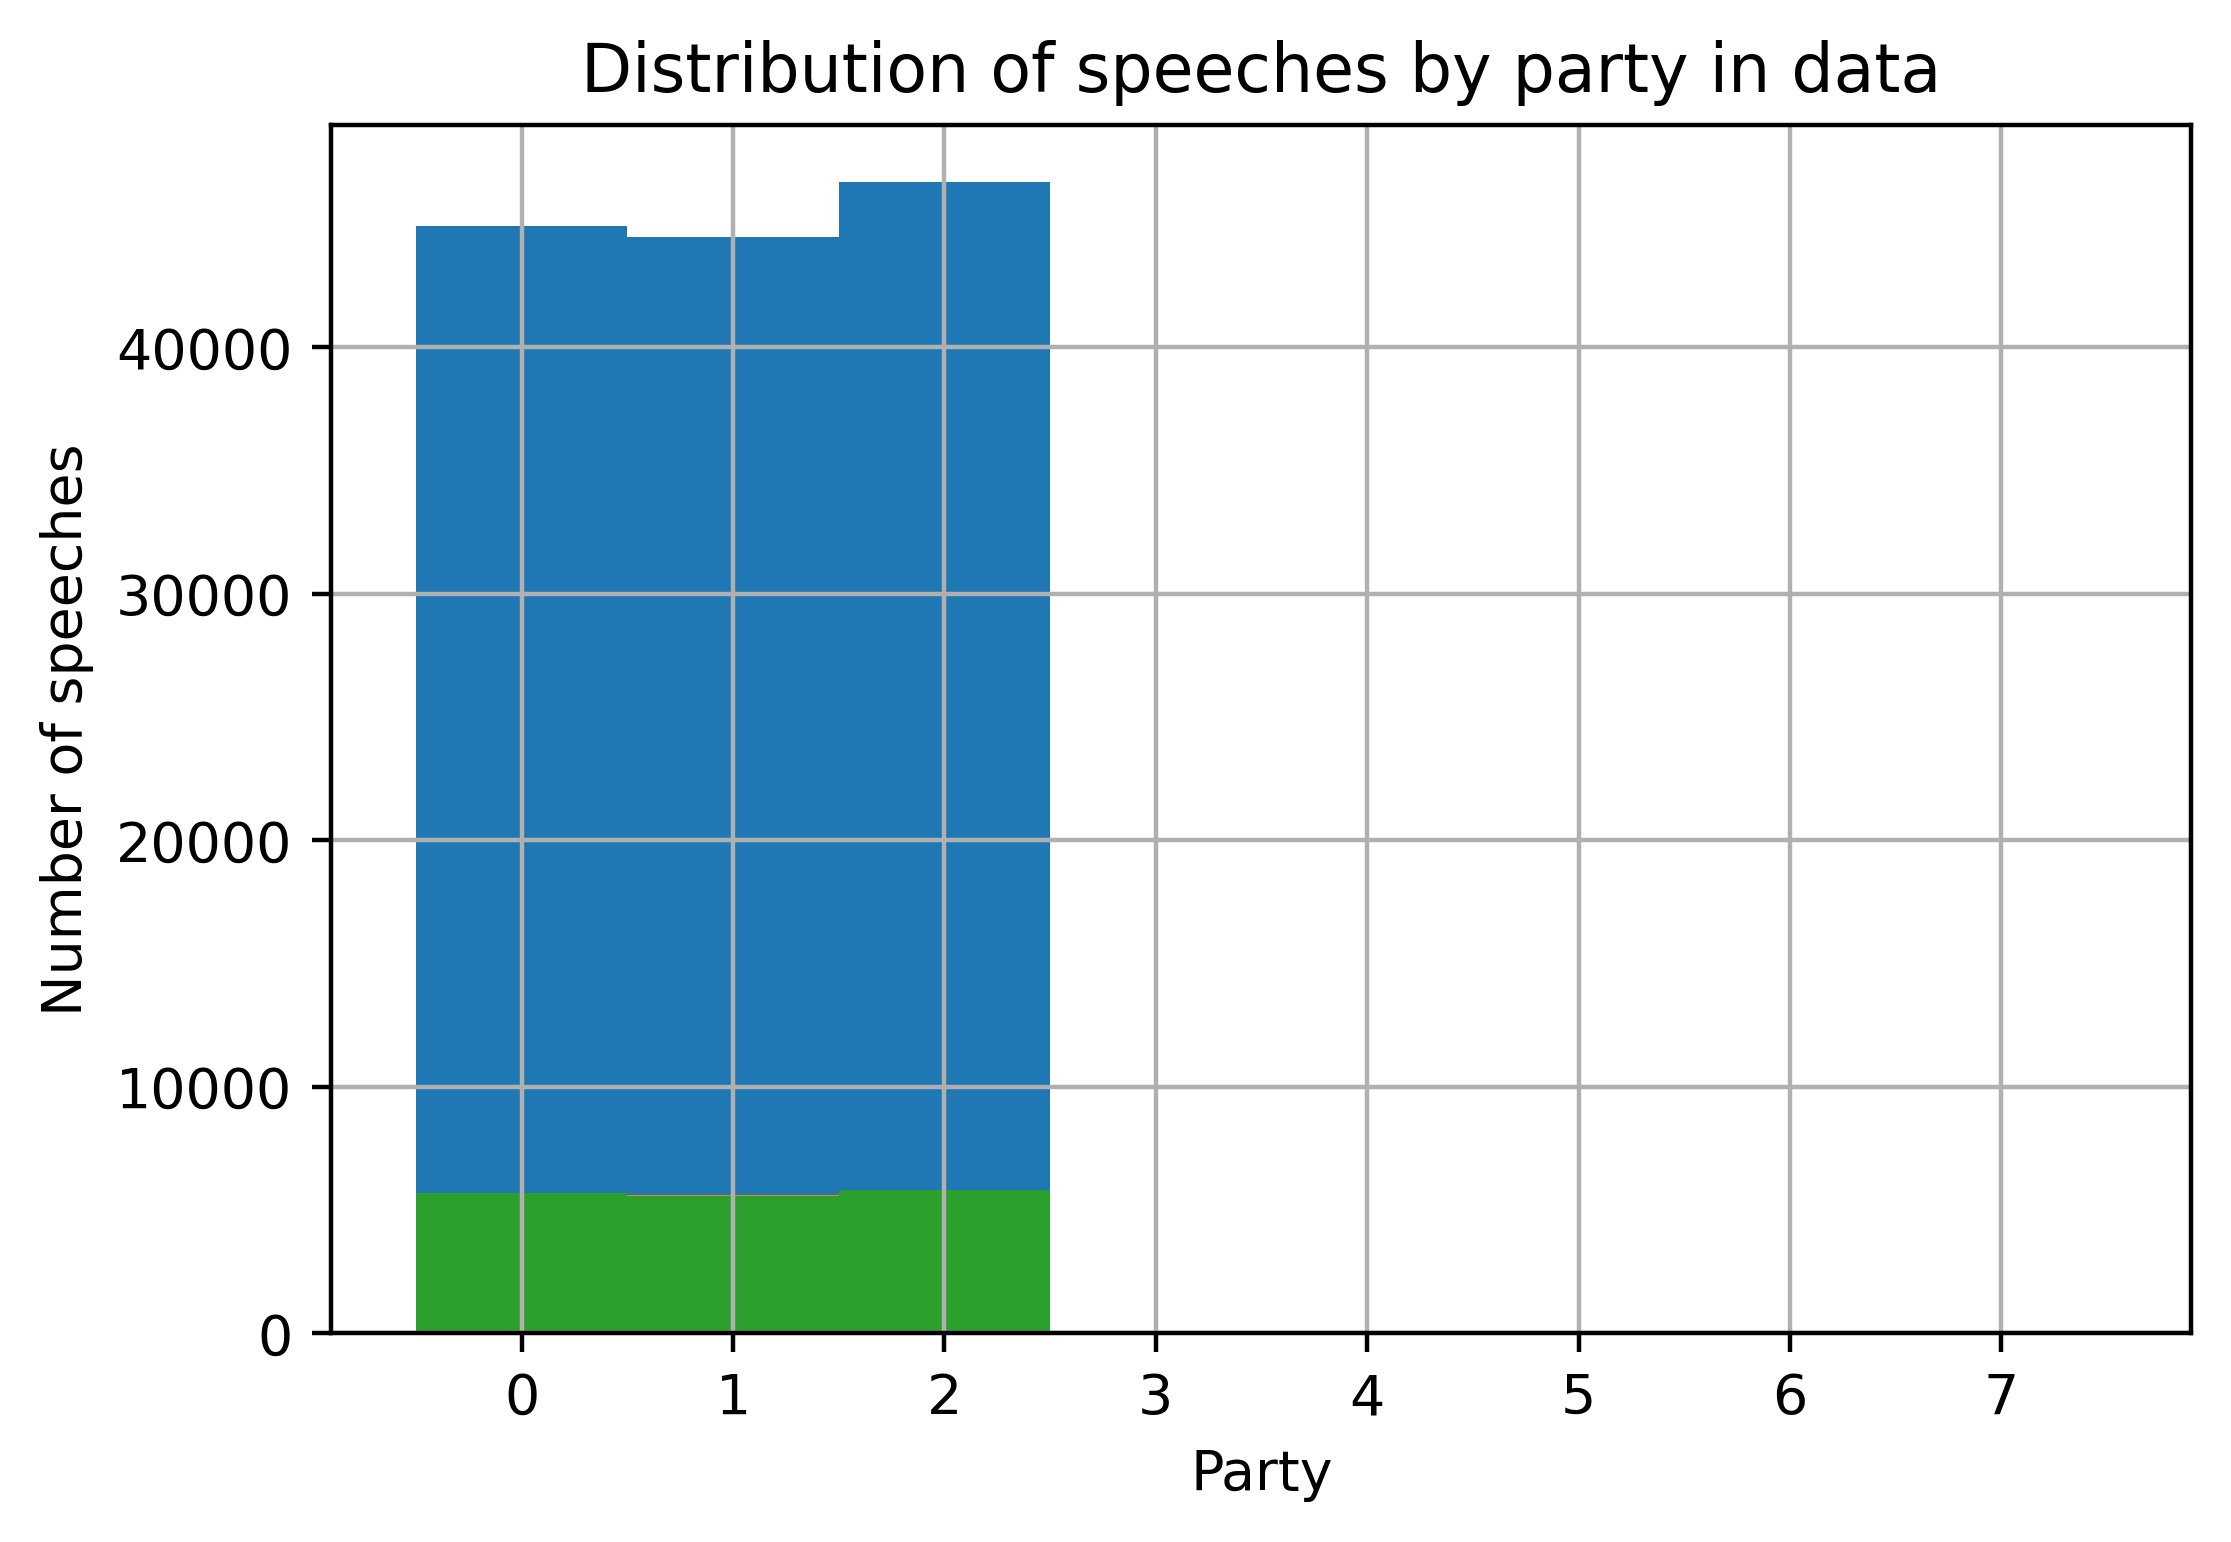

In [27]:
# Let's see how it looks in a histogram

party_bins = np.array(range(0,9)) - 0.5

import matplotlib as mpl # Adds plotting functionality
mpl.rcParams['figure.dpi'] = 400 # This gives high resolution figures


train_data['label'].hist(bins = party_bins, alpha = 0.5)

validation_data['label'].hist(bins = party_bins, alpha = 0.5)

test_data['label'].hist(bins = party_bins, alpha = 0.5)
plt.title('Distribution of speeches by party in data')
plt.xlabel('Party')
plt.ylabel('Number of speeches')

In [28]:
# Let's see what the data looks like
print('Here is the dataset:')
pprint(dataset)
print('This is an example sentence from the dataset:')
pprint(dataset['train'][0])

Here's the dataset:
{'test': Dataset({
    features: ['text', 'label'],
    num_rows: 17012
}),
 'train': Dataset({
    features: ['text', 'label'],
    num_rows: 136097
}),
 'validation': Dataset({
    features: ['text', 'label'],
    num_rows: 17013
})}
This is an example sentence from the dataset:
{'label': 0,
 'text': 'Arvoisa puhemies! Minäkin olisin reagoinut tähän ed. Soinin '
         'pohdiskeluun vuoroviisaudesta. Minä olen usein käyttänyt termistä '
         '"ryhmäkuria" termiä "ryhmäsolidaarisuus", jonka taustalla '
         'epäilemättä on juuri tämä ed. Soinin esille ottama kanta, että '
         'todella tässä on vuoroviisautta. Me emme voi erikoistua kaikkiin '
         'kysymyksiin, ja on erinomaista, että suuressa ryhmässä on '
         'mahdollisuuksia siihen, että me voimme nojautua myöskin siihen '
         'viisauteen, kuten te käytitte termiä, joka kollegoilla on '
         'erityisvaliokunnissa kuunneltuaan asiantuntijoita. Sen vastakohtana, '
         'ed. Soi

In [29]:
# Get the number of labels, which is required for the model
train_labels = dataset['train']['label']
test_labels = dataset['test']['label']
label_ints = sorted(list(set(train_labels + test_labels)))
num_labels = len(set(train_labels + test_labels))
print('Here are the labels:')
print(label_ints)
print('Number of labels:')
print(num_labels)

# Dict for converting label numbers back into party names
id2label = {0 : 'SD', 1 : 'KOK', 2 : 'KESK', 3 : 'VIHR', 4 : 'VAS', 5 : 'PS', 6 : 'R', 7 : 'KD'}

# Get the labels that are actually in the current dataset in correct order
id2label_in_data = []
for i in label_ints:
    id2label_in_data.append(id2label[i])

print('Here are the labels in text form:')
print(id2label_in_data)

Here are the labels:
[0, 1, 2]
Number of labels:
3
Here are the labels in text form:
['SD', 'KOK', 'KESK']


### Tokenization

In [30]:
# Initialise model and tokenizer
model_name = 'TurkuNLP/bert-base-finnish-cased-v1'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

loading configuration file https://huggingface.co/TurkuNLP/bert-base-finnish-cased-v1/resolve/main/config.json from cache at /users/tarkkaot/.cache/huggingface/transformers/e27939251243299384d3c49756d6710f25a683fa4d5e00e6f42fe6cc59202f07.1b2c5b5f39fed7ac39db55c0d2566730a96257ac7215ad6c2a8a109e2ccf1ccd
Model config BertConfig {
  "_name_or_path": "TurkuNLP/bert-base-finnish-cased-v1",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50105
}

loading file https://huggingface.co/TurkuNLP/bert-bas

In [31]:
# Define a simple function that applies the tokenizer
# Maximum length of BERT models is 512 due to the position embeddings
def tokenize(example):
    return tokenizer(
        example['text'],
        max_length=512,
        truncation=True
    )
    
# Apply the tokenizer to the whole dataset using .map()
# Batched means that tokenization is done in batches, and hence, faster
print('Tokenizing...')
dataset = dataset.map(tokenize, batched=True)

Tokenizing...


100%|██████████| 18/18 [00:13<00:00,  1.33ba/s]


In [32]:
# Print test sample of tokens
example = dataset['train'][0]['text']
print('This is an example sentence tokenized:')
tokenized = tokenizer(example)
pprint(tokenized)
print('Tokens:')
tokens = tokenizer.tokenize(example)
pprint(tokens)

This is an example sentence tokenized:
{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [102, 42525, 17397, 380, 14024, 3546, 17390, 885, 1552, 493, 111,
               12162, 27187, 518, 3460, 48519, 3233, 111, 2172, 667, 1561, 7050,
               21762, 492, 245, 4321, 42848, 245, 35993, 245, 4321, 35084,
               12547, 1257, 245, 119, 975, 6369, 26999, 145, 1068, 871, 493,
               111, 12162, 4231, 1751, 162,

In [33]:
print('Here is the dataset after tokenization:')
pprint(dataset)

Here is the dataset after tokenization:
{'test': Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 17012
}),
 'train': Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 136097
}),
 'validation': Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 17013
})}


### Training

In [34]:
# Initialise model for sequence classification
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label = id2label_in_data)

loading configuration file https://huggingface.co/TurkuNLP/bert-base-finnish-cased-v1/resolve/main/config.json from cache at /users/tarkkaot/.cache/huggingface/transformers/e27939251243299384d3c49756d6710f25a683fa4d5e00e6f42fe6cc59202f07.1b2c5b5f39fed7ac39db55c0d2566730a96257ac7215ad6c2a8a109e2ccf1ccd
Model config BertConfig {
  "_name_or_path": "TurkuNLP/bert-base-finnish-cased-v1",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": [
    "SD",
    "KOK",
    "KESK"
  ],
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.

In [35]:
# Set training hyperparameters
trainer_args = transformers.TrainingArguments(
    output_dir = output_dir,
    save_total_limit = 1, # Only keep the best model in the end
    save_strategy = 'steps',
    evaluation_strategy = 'steps',
    logging_strategy= 'steps',
    load_best_model_at_end = True,
    eval_steps = 100,
    logging_steps = 100,
    learning_rate = 0.00001,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    max_steps = 1500,
    label_smoothing_factor = 0.1
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [36]:
# Function for computing accuracy and F score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def get_example(index):
    return dataset['validation'][index]['text'] # Returns text from validation data at index 'index' to show in confusion matrix


def compute_metrics(pred):
    experiment = comet_ml.get_global_experiment() #Get access to the current experiment created in another part of the code

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average = 'macro'
    )
    acc = accuracy_score(labels, preds)

    if experiment:
        step = int(experiment.curr_step) if experiment.curr_step is not None else 0
        experiment.set_step(step)
        experiment.log_confusion_matrix(
            y_true = labels,
            y_predicted = preds,
            file_name = f'confusion-matrix-step-{step}.json',
            labels = id2label_in_data,
            index_to_example_function = get_example,
        )

    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

In [37]:
# Data collator pads the input to be of uniform size
data_collator = transformers.DataCollatorWithPadding(tokenizer)

# Argument gives the number of steps of patience before early stopping
early_stopping = transformers.EarlyStoppingCallback(
    early_stopping_patience = 5)

In [38]:
# Print a sample of test and validation labels to see that they are not ordered
print('Sample of test and validation labels:')
print(dataset['validation']['label'][:30])
print(dataset['test']['label'][:30])

Sample of test and validation labels:
[2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 0, 0, 2, 2, 1, 2, 0]
[1, 0, 2, 0, 0, 2, 0, 0, 0, 1, 2, 1, 0, 2, 1, 2, 2, 0, 0, 1, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1]


In [39]:
# Train model using arguments defined above

%env COMET_MODE = ONLINE
%env COMET_LOG_ASSETS = TRUE

trainer = None
trainer = transformers.Trainer(
    model = model,
    args = trainer_args,
    train_dataset = dataset['train'],
    eval_dataset = dataset['validation'],
    compute_metrics = compute_metrics,
    data_collator = data_collator,
    tokenizer = tokenizer,
    callbacks = [early_stopping]
)

trainer.train()

env: COMET_MODE=ONLINE
env: COMET_LOG_ASSETS=TRUE


max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/scratch/project_2006385/otto/venv/lib64/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 136097
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1500
COMET WARNING: As you are running in a Jupyter environment, you will need to call `

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,1.103100,1.082613,0.401281,0.367212,0.438250,0.403169
200,1.085400,1.054614,0.463881,0.457955,0.466378,0.463155
300,1.056600,1.045020,0.468230,0.442616,0.486953,0.466375
400,1.043700,1.016888,0.512255,0.511983,0.516291,0.512510
500,1.019900,1.000107,0.530594,0.529529,0.534823,0.530808
600,1.025600,0.990132,0.533592,0.530875,0.540635,0.533717
700,0.992800,1.015001,0.507729,0.493428,0.570559,0.509422
800,0.972700,0.991229,0.534532,0.529535,0.562612,0.535684
900,0.972500,0.955517,0.563275,0.563290,0.563579,0.563256
1000,0.961400,0.972355,0.552342,0.548132,0.575828,0.553423


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17013
  Batch size = 32
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17013
  Batch size = 32
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17013
  Batch size = 32
The fol

COMET ERROR: We failed to read file /scratch/project_2006385/otto/results/models/model-with-comet/model3/checkpoint-1500/optimizer.pt for uploading.
Please double-check the file path and permissions
COMET ERROR: We failed to read file /scratch/project_2006385/otto/results/models/model-with-comet/model3/checkpoint-1500/config.json for uploading.
Please double-check the file path and permissions
COMET ERROR: We failed to read file /scratch/project_2006385/otto/results/models/model-with-comet/model3/checkpoint-1500/special_tokens_map.json for uploading.
Please double-check the file path and permissions
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ottotarkka/semparl-classifier/979f2d3f9d894d218accb409920864a5
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch [31]                  

COMET INFO:     args/tpu_metrics_debug                  : False
COMET INFO:     args/tpu_num_cores                      : None
COMET INFO:     args/train_batch_size                   : 32
COMET INFO:     args/use_legacy_prediction_loop         : False
COMET INFO:     args/warmup_ratio                       : 0.0
COMET INFO:     args/warmup_steps                       : 0
COMET INFO:     args/weight_decay                       : 0.0
COMET INFO:     args/world_size                         : 1
COMET INFO:     args/xpu_backend                        : None
COMET INFO:     config/_auto_class                      : None
COMET INFO:     config/_name_or_path                    : TurkuNLP/bert-base-finnish-cased-v1
COMET INFO:     config/add_cross_attention              : False
COMET INFO:     config/architectures                    : ['BertForMaskedLM']
COMET INFO:     config/attention_probs_dropout_prob     : 0.1
COMET INFO:     config/attribute_map                    : {}
COMET INFO:     con

TrainOutput(global_step=1500, training_loss=1.0002663269042968, metrics={'train_runtime': 4396.0985, 'train_samples_per_second': 10.919, 'train_steps_per_second': 0.341, 'total_flos': 1.2627651590785728e+16, 'train_loss': 1.0002663269042968, 'epoch': 0.35})

### Evaluation

In [40]:
# Evaluate results on test data

eval_results = trainer.evaluate(dataset['test'])
pprint(eval_results)
print('Accuracy:', eval_results['eval_accuracy'])

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17012
  Batch size = 32


{'epoch': 0.35,
 'eval_accuracy': 0.5713026099224077,
 'eval_f1': 0.5694809890783761,
 'eval_loss': 0.9470111727714539,
 'eval_precision': 0.5895004031503844,
 'eval_recall': 0.5727989833688426,
 'eval_runtime': 182.8127,
 'eval_samples_per_second': 93.057,
 'eval_steps_per_second': 2.91}
Accuracy: 0.5713026099224077


In [41]:
# Print a few example predictions
model.to('cpu')

examples = dataset['test'].select(range(5))

pipeline = transformers.TextClassificationPipeline(model = model,
                                                  tokenizer = tokenizer,
                                                  truncation = True,
                                                  max_length = 512)
    
for i in range(len(examples)):
    print('speech:', examples['text'][i])
    print('predicted label:', pipeline(examples['text'][i])[0])
    print('true label:', id2label[examples['label'][i]])
    print('')

speech: Arvoisa puhemies! Lainan antaminen Kreikalle on hyvin vastenmielistä, ja siihen todellakin liittyy isoja riskejä, mutta kyllä se on välttämätöntä. Emme me sitä tee sen takia, että me haluaisimme pelastaa kreikkalaiset, jotka ovat huijanneet ja valehdelleet ja olleet vastuuttomia, vaan me todellakin haluamme turvata sen vakaan talous- ja työllisyyskehityksen Suomessa. Haluamme pelastaa suomalaisen hyvinvointiyhteiskunnan. Varsin moni suomalainen tässä parhaillaan miettii ja kuuntelee ja kysyisi varmasti ministeri Kataiselta, jos täällä olisi, onko nyt varmasti tehty kaikki mahdollinen tämän lainapaketin kokoamisen lisäksi, että tämä kriisi ei todellakaan eskaloidu Euroopassa, ja mitä tästä meidän pitää oppia, mitä muutoksia tulee tapahtumaan euromaiden kesken. Täällä on monta kertaa viitattu rahoituslaitoksiin, pankkeihin. Minkälaista valvontaa esimerkiksi sillä saralla tullaan tekemään tulevaisuudessa, eli mitä tästä opimme? Toivon, että tähän ministeri Katainen vielä vastaa ni

predicted label: {'label': 'SD', 'score': 0.6426900625228882}
true label: SD



In [42]:
#the xp.end() command is needed when running code in notebook

xp = comet_ml.Experiment()
xp.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: One or more required CGROUP controllers disabled at kernel level.
COMET INFO: Couldn't find a Git repository in '/scratch/project_2006385/otto/scripts' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/ottotarkka/semparl-classifier/390ad80eeff8492486820cd72061f0d6

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ottotarkka/semparl-classifier/390ad80eeff8492486820cd72061f0d6
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename   

In [45]:
# let's get the predictions and confidence and add them to a table for later inspection

model.to('cuda')

test_pred = trainer.predict(dataset['test'])
predictions = test_pred.predictions

pred_labels = predictions.argmax(-1)
pred_confidence = predictions.max(-1)

test_data['prediction'] = pred_labels
test_data['pred_confidence'] = pred_confidence
pprint(test_data.head(10))

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 17012
  Batch size = 32


In [81]:
test_data.to_csv(f'../results/tables/predictions_{xp_name}.csv', index = False)

array([1, 0, 1, ..., 2, 1, 0])
array([0.7411572 , 1.1725692 , 0.77738625, ..., 0.30767563, 1.2739313 ,
       0.60099924], dtype=float32)


AttributeError: 'numpy.ndarray' object has no attribute 'args'